In [ ]:
# prompt: mount google drive

from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


Epoch 1/50, Loss: 492.4664
Epoch 2/50, Loss: 267.5941
Epoch 3/50, Loss: 243.1465
Epoch 4/50, Loss: 232.8118
Epoch 5/50, Loss: 226.4683
Epoch 6/50, Loss: 222.5529
Epoch 7/50, Loss: 218.6674
Epoch 8/50, Loss: 214.7549
Epoch 9/50, Loss: 212.1326
Epoch 10/50, Loss: 210.2182
Epoch 11/50, Loss: 208.4203
Epoch 12/50, Loss: 207.3708
Epoch 13/50, Loss: 206.3446
Epoch 14/50, Loss: 205.1970
Epoch 15/50, Loss: 204.3513
Epoch 16/50, Loss: 203.6286
Epoch 17/50, Loss: 202.7023
Epoch 18/50, Loss: 202.2537
Epoch 19/50, Loss: 201.4412
Epoch 20/50, Loss: 200.9414
Epoch 21/50, Loss: 200.1796
Epoch 22/50, Loss: 199.9305
Epoch 23/50, Loss: 199.2976
Epoch 24/50, Loss: 198.8739
Epoch 25/50, Loss: 198.6916
Epoch 26/50, Loss: 198.0925
Epoch 27/50, Loss: 197.7266
Epoch 28/50, Loss: 197.4174
Epoch 29/50, Loss: 196.9605
Epoch 30/50, Loss: 196.8326
Epoch 31/50, Loss: 196.4361
Epoch 32/50, Loss: 196.0796
Epoch 33/50, Loss: 195.9833
Epoch 34/50, Loss: 195.6351
Epoch 35/50, Loss: 195.4815
Epoch 36/50, Loss: 195.0214
E

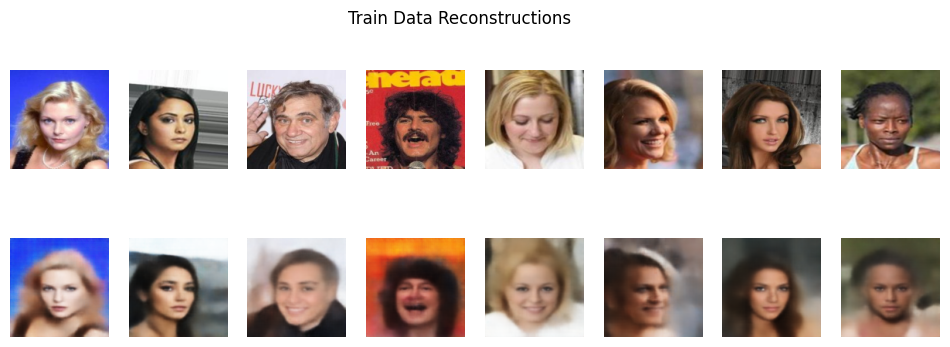

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import matplotlib.pyplot as plt

import kagglehub
from torch.utils.data import DataLoader, Subset
from pathlib import Path
from PIL import Image
from torchvision.datasets import ImageFolder

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Hyperparameters
LATENT_DIM = 128
BATCH_SIZE = 128
LEARNING_RATE = 1e-3
EPOCHS = 50

# Download dataset using kagglehub
path = kagglehub.dataset_download("jessicali9530/celeba-dataset")
data_dir = Path(path) / "img_align_celeba"

# Dataset transformation
transform = transforms.Compose([
    transforms.Resize((128, 128)),  # Resize to 128x128
    transforms.ToTensor(),
])

# Load CelebA dataset from KaggleHub
dataset = ImageFolder(root=str(data_dir.parent), transform=transform)

# Select random 80k images from first 162770 images
torch.manual_seed(42)
indices = torch.randperm(162770)[:80000]
train_dataset = Subset(dataset, indices.tolist())

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)

# Define VAE model
class VAE(nn.Module):
    def __init__(self, latent_dim):
        super(VAE, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 32, 4, 2, 1), nn.ReLU(),
            nn.Conv2d(32, 64, 4, 2, 1), nn.ReLU(),
            nn.Conv2d(64, 128, 4, 2, 1), nn.ReLU(),
            nn.Conv2d(128, 256, 4, 2, 1), nn.ReLU()
        )
        self.fc_mu = nn.Linear(256 * 8 * 8, latent_dim)
        self.fc_logvar = nn.Linear(256 * 8 * 8, latent_dim)
        self.fc_decode = nn.Linear(latent_dim, 256 * 8 * 8)
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(256, 128, 4, 2, 1), nn.ReLU(),
            nn.ConvTranspose2d(128, 64, 4, 2, 1), nn.ReLU(),
            nn.ConvTranspose2d(64, 32, 4, 2, 1), nn.ReLU(),
            nn.ConvTranspose2d(32, 3, 4, 2, 1), nn.Sigmoid()
        )

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def encode(self, x):
        x = self.encoder(x).view(x.size(0), -1)
        mu, logvar = self.fc_mu(x), self.fc_logvar(x)
        z = self.reparameterize(mu, logvar)
        return z, mu, logvar

    def decode(self, z):
        x = self.fc_decode(z).view(z.size(0), 256, 8, 8)
        return self.decoder(x)

    def forward(self, x):
        z, mu, logvar = self.encode(x)
        recon_x = self.decode(z)
        return recon_x, mu, logvar

# Loss function
def loss_function(recon_x, x, mu, logvar):
    recon_loss = nn.functional.mse_loss(recon_x, x, reduction='sum')
    kl_div = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return recon_loss + kl_div

# Train the model
vae = VAE(LATENT_DIM).to(device)
optimizer = optim.Adam(vae.parameters(), lr=LEARNING_RATE)

for epoch in range(EPOCHS):
    vae.train()
    train_loss = 0
    for imgs, _ in train_loader:
        imgs = imgs.to(device)
        optimizer.zero_grad()
        recon_imgs, mu, logvar = vae(imgs)
        loss = loss_function(recon_imgs, imgs, mu, logvar)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    print(f"Epoch {epoch+1}/{EPOCHS}, Loss: {train_loss/len(dataset):.4f}")

print("Training complete!")

# Display some reconstructions
def show_reconstructions(loader, title):
    vae.eval()
    with torch.no_grad():
        imgs, _ = next(iter(loader))
        imgs = imgs.to(device)
        recon_imgs, _, _ = vae(imgs)
        imgs, recon_imgs = imgs.cpu(), recon_imgs.cpu()
        fig, axes = plt.subplots(2, 8, figsize=(12, 4))
        for i in range(8):
            axes[0, i].imshow(imgs[i].permute(1, 2, 0))
            axes[0, i].axis('off')
            axes[1, i].imshow(recon_imgs[i].permute(1, 2, 0))
            axes[1, i].axis('off')
        plt.suptitle(title)
        plt.show()

show_reconstructions(train_loader, "Train Data Reconstructions")


In [ ]:
# prompt: save model on drive

# Save the model's state_dict()
torch.save(vae.state_dict(), '/content/drive/My Drive/vae_model_celeba_50_convention_gpt.pth')
print("Model saved to Google Drive.")


Model saved to Google Drive.
